# Ring Attractor Network Implementation

This notebook implements a ring attractor network for head direction cells with the following architecture:
- Excitatory neurons arranged in a ring (representing head directions 0-360°)
- Inhibitory neurons providing global inhibition
- Fixed excitatory-to-excitatory connections (ring topology)
- Trainable inhibitory connections (E→I and I→E only, no I→I)

## Import Required Libraries

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Ring Attractor Network Class

The main network class that implements the ring attractor dynamics.

In [8]:
class RingAttractorNetwork(nn.Module):
    """
    Ring attractor network for head direction cells.
    
    Architecture:
    - Excitatory neurons arranged in a ring (representing head directions 0-360°)
    - Inhibitory neurons providing global inhibition
    - Fixed excitatory-to-excitatory connections (ring topology)
    - Trainable inhibitory connections (E->I and I->E only, no I->I)
    """
    
    def __init__(self, n_exc=800, n_inh=200, sigma_ee=0.1, tau_e=10.0, tau_i=5.0, 
                 dt=0.1, device='cpu'):
        super().__init__()
        
        self.n_exc = n_exc  # Number of excitatory neurons
        self.n_inh = n_inh  # Number of inhibitory neurons
        self.device = device
        
        # Time constants (in ms)
        self.tau_e = tau_e  # Excitatory neuron time constant
        self.tau_i = tau_i  # Inhibitory neuron time constant
        self.dt = dt        # Integration time step
        
        # Preferred directions of excitatory neurons (evenly distributed around ring)
        angles = torch.linspace(0, 2*np.pi, n_exc, device=device)
        self.register_buffer('preferred_dirs', angles)
        
        # Fixed excitatory-to-excitatory connectivity (ring structure)
        self.register_buffer('W_EE', self._create_ring_weights(sigma_ee))
        
        # Trainable inhibitory connections (E->I and I->E only, no I->I)
        self.W_EI = nn.Parameter(torch.randn(n_exc, n_inh, device=device) * 0.1)
        self.W_IE = nn.Parameter(torch.randn(n_inh, n_exc, device=device) * 0.1)
        
        # Gain parameters
        self.g_ee = nn.Parameter(torch.tensor(1.0, device=device))
        self.g_ei = nn.Parameter(torch.tensor(1.5, device=device))
        self.g_ie = nn.Parameter(torch.tensor(2.0, device=device))
        
        # Input gain
        self.g_input = nn.Parameter(torch.tensor(1.0, device=device))
        
        # Noise parameters
        self.noise_exc = nn.Parameter(torch.tensor(0.1, device=device))
        self.noise_inh = nn.Parameter(torch.tensor(0.05, device=device))
        
        # Initialize states
        self.reset_state()
        
    def _create_ring_weights(self, sigma):
        """Create ring-structured excitatory weights based on angular distance."""
        # Calculate angular distances between all neuron pairs
        angles = self.preferred_dirs
        angle_diff = angles.unsqueeze(0) - angles.unsqueeze(1)
        
        # Wrap distances to [-pi, pi]
        angle_diff = torch.atan2(torch.sin(angle_diff), torch.cos(angle_diff))
        
        # Gaussian connectivity based on angular distance
        W = torch.exp(-0.5 * (angle_diff / sigma)**2)
        
        # Normalize weights
        W = W / W.sum(dim=1, keepdim=True)
        
        # Remove self-connections
        W.fill_diagonal_(0)
        
        return W
    
    def reset_state(self):
        """Reset neural activities to baseline."""
        self.r_e = torch.zeros(self.n_exc, device=self.device)
        self.r_i = torch.zeros(self.n_inh, device=self.device)
        
    def initialize_bump(self, direction, width=0.3, amplitude=1.0):
        """
        Initialize activity with a bump at specified direction.
        
        Args:
            direction: Head direction in radians [0, 2π]
            width: Width of the bump (in radians)
            amplitude: Peak amplitude of the bump
        """
        # Calculate distance from preferred direction
        angle_diff = self.preferred_dirs - direction
        angle_diff = torch.atan2(torch.sin(angle_diff), torch.cos(angle_diff))
        
        # Create Gaussian bump
        self.r_e = amplitude * torch.exp(-0.5 * (angle_diff / width)**2)
        self.r_i = torch.zeros(self.n_inh, device=self.device)
        
    def forward(self, external_input=None, steps=1):
        """
        Forward dynamics of the ring attractor network.
        
        Args:
            external_input: External input to excitatory neurons (n_exc,)
            steps: Number of integration steps
            
        Returns:
            Dictionary with final activities and trajectories
        """
        # Store trajectories
        r_e_trajectory = []
        r_i_trajectory = []
        
        for _ in range(steps):
            # Store current state
            r_e_trajectory.append(self.r_e.clone())
            r_i_trajectory.append(self.r_i.clone())
            
            # Calculate inputs to each population
            # Excitatory neurons receive: E->E, I->E, and external input
            input_e = (self.g_ee * torch.matmul(self.W_EE, self.r_e) - 
                      self.g_ie * torch.matmul(self.W_IE, self.r_i))
            
            if external_input is not None:
                input_e += self.g_input * external_input
                
            # Inhibitory neurons receive: E->I only (no I->I connections)
            input_i = self.g_ei * torch.matmul(self.W_EI.t(), self.r_e)
            
            # Add noise
            input_e += self.noise_exc * torch.randn_like(input_e)
            input_i += self.noise_inh * torch.randn_like(input_i)
            
            # Update activities with time constants
            self.r_e += self.dt * (-self.r_e + F.relu(input_e)) / self.tau_e
            self.r_i += self.dt * (-self.r_i + F.relu(input_i)) / self.tau_i
            
            # Ensure non-negative rates
            self.r_e = F.relu(self.r_e)
            self.r_i = F.relu(self.r_i)
        
        return {
            'r_e': self.r_e,
            'r_i': self.r_i,
            'r_e_trajectory': torch.stack(r_e_trajectory),
            'r_i_trajectory': torch.stack(r_i_trajectory)
        }
    
    def decode_direction(self):
        """Decode current head direction from population activity."""
        # Population vector decoding
        if self.r_e.sum() > 0:
            # Weighted circular mean
            x = (self.r_e * torch.cos(self.preferred_dirs)).sum()
            y = (self.r_e * torch.sin(self.preferred_dirs)).sum()
            decoded_dir = torch.atan2(y, x)
            
            # Confidence (vector magnitude)
            confidence = torch.sqrt(x**2 + y**2) / self.r_e.sum()
        else:
            decoded_dir = torch.tensor(0.0, device=self.device)
            confidence = torch.tensor(0.0, device=self.device)
            
        return decoded_dir, confidence

## Visualization Functions

In [9]:
def plot_weight_structure(model):
    """Visualize the connectivity structure of the network."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Get weights
    W_EE = model.W_EE.detach().cpu().numpy()
    W_EI = model.W_EI.detach().cpu().numpy()
    W_IE = model.W_IE.detach().cpu().numpy()
    
    # E→E weights
    im1 = axes[0, 0].imshow(W_EE, cmap='hot', aspect='auto')
    axes[0, 0].set_title('E→E Weights (Fixed)')
    axes[0, 0].set_xlabel('From Neuron')
    axes[0, 0].set_ylabel('To Neuron')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # E→I weights
    im2 = axes[0, 1].imshow(W_EI.T, cmap='RdBu_r', aspect='auto')
    axes[0, 1].set_title('E→I Weights (Trainable)')
    axes[0, 1].set_xlabel('From E Neuron')
    axes[0, 1].set_ylabel('To I Neuron')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # I→E weights
    im3 = axes[1, 0].imshow(W_IE, cmap='RdBu_r', aspect='auto')
    axes[1, 0].set_title('I→E Weights (Trainable)')
    axes[1, 0].set_xlabel('From I Neuron')
    axes[1, 0].set_ylabel('To E Neuron')
    plt.colorbar(im3, ax=axes[1, 0])
    
    # Network architecture diagram
    ax = axes[1, 1]
    ax.text(0.5, 0.8, 'Network Architecture', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.6, 'Excitatory Ring (E)', ha='center', va='center', 
            fontsize=12, color='blue', transform=ax.transAxes)
    ax.text(0.5, 0.5, '↕', ha='center', va='center', 
            fontsize=16, transform=ax.transAxes)
    ax.text(0.5, 0.4, 'Inhibitory Pool (I)', ha='center', va='center', 
            fontsize=12, color='red', transform=ax.transAxes)
    ax.text(0.5, 0.2, 'E→E: Fixed ring structure\nE→I: Trainable\nI→E: Trainable\nI→I: None', 
            ha='center', va='center', fontsize=10, transform=ax.transAxes)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    plt.suptitle('Network Connectivity Structure', fontsize=16)
    plt.tight_layout()
    return fig

## Initialize and Test the Network

In [10]:
# Set random seeds for reproducibility
#torch.manual_seed(42)
#np.random.seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Create network instance
model = RingAttractorNetwork(
    n_exc=800,      
    n_inh=200,      
    sigma_ee=0.15,  # Width of excitatory connections
    tau_e=10.0,     # Excitatory time constant (ms)
    tau_i=5.0,      # Inhibitory time constant (ms)
    dt=0.1,         # Time step (ms)
    device=device
)

print(f"Network created with {model.n_exc} excitatory and {model.n_inh} inhibitory neurons")
print("Key architectural features:")
print("- No inhibitory-to-inhibitory (I→I) connections")
print("- Excitatory ring with fixed connectivity")
print("- Trainable E→I and I→E connections")

Network created with 800 excitatory and 200 inhibitory neurons
Key architectural features:
- No inhibitory-to-inhibitory (I→I) connections
- Excitatory ring with fixed connectivity
- Trainable E→I and I→E connections


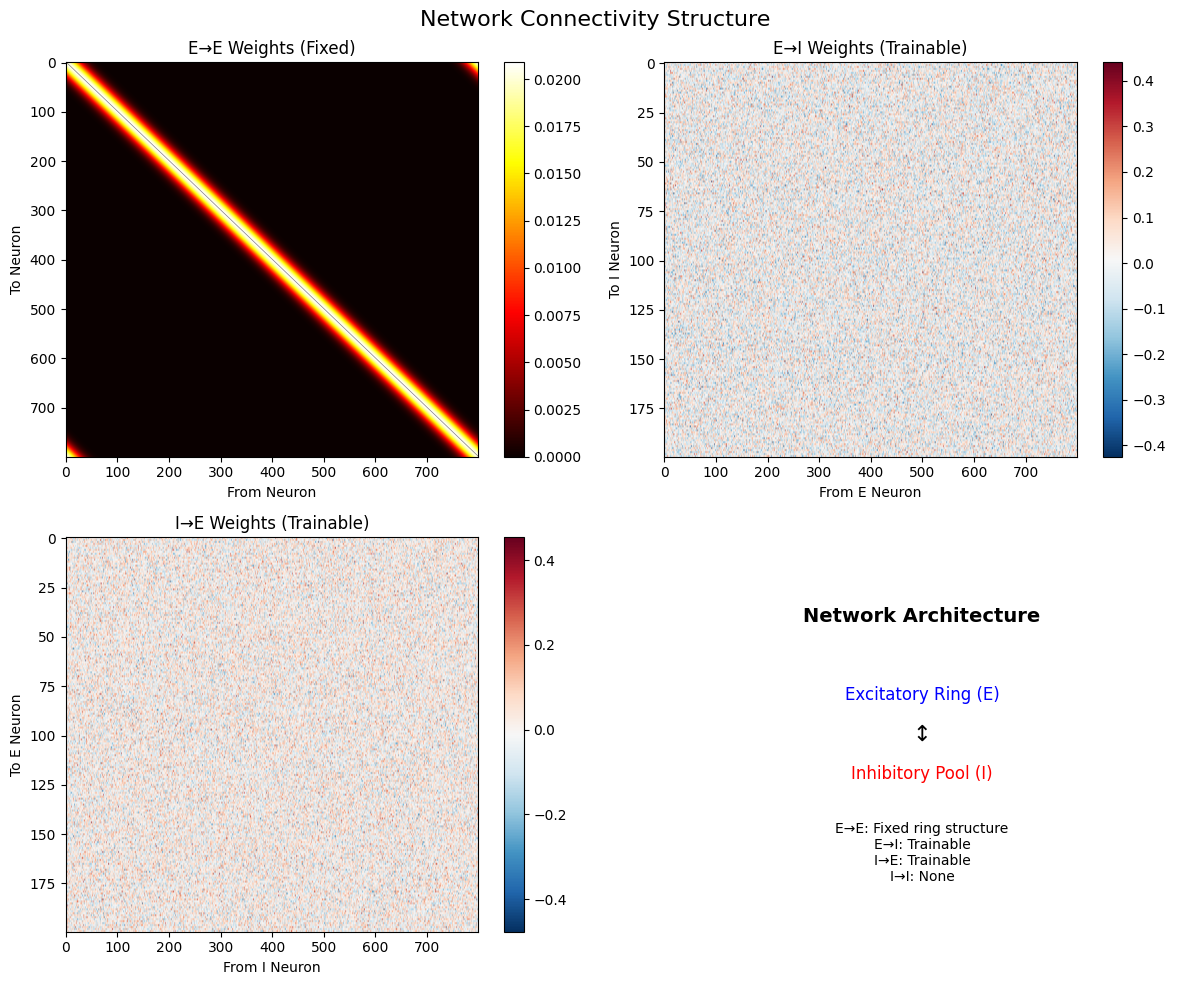

In [12]:
# Visualize connectivity
plot_weight_structure(model)
plt.show()